In [1]:
# !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Section 1 : Load the Model

model_name = "./models/gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name)


In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [4]:
# Section 2. How to generate a token from the model output tensors


In [5]:
# 1. Tokenize input prompt

prompt = "The strong ML engineer can do"
inputs = tokenizer(prompt, return_tensors ="pt")
inputs 

{'input_ids': tensor([[  464,  1913, 10373, 11949,   460,   466]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [8]:
# pass the inputs to the model and retrieve the logits 
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits 
print(logits.shape)

torch.Size([1, 6, 50257])


In [9]:
last_logits = logits[0,-1,:]
next_token_id = last_logits.argmax()
next_token_id

tensor(340)

In [10]:
# decode the most likely token 
tokenizer.decode(next_token_id)

' it'

In [11]:
# the 10 next words 
top_k = torch.topk(last_logits, k = 10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' it',
 ' a',
 ' this',
 ' the',
 ' anything',
 ' everything',
 ' all',
 ' things',
 ' what',
 ' much']

In [14]:
next_inputs = {
    "input_ids":torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1,1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim = 1
    )
}

In [15]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  1913, 10373, 11949,   460,   466,   340]]) torch.Size([1, 7])
tensor([[1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 7])


ok so the idea is that model generates next word, by knowing what it said last time

The input_ids and attention_mask are updated iteratively to reflect the growing sequence, ensuring that the model's predictions are based on all the previous context. This way, the model "remembers" what it has generated so far, which influences its predictions for the next words or tokens in the sequence.



Absolutely, the generation process can't and shouldn't continue indefinitely. There are several strategies used to determine when a model should stop generating further tokens:

Maximum Length: One common approach is to set a maximum sequence length. Once the generated sequence reaches this length, the generation process stops. This prevents excessively long outputs and ensures computational efficiency.
End-of-Sequence Token: Many models are trained to generate a special token (often denoted as <EOS> for End Of Sequence) that signals the completion of a sentence or a logical end to the output. When the model generates this token, the process stops.
Probability Threshold: In some cases, generation can be stopped if the model's confidence in its next predictions falls below a certain threshold. If the predicted probability of the next token is very low, it might indicate that the model is unsure how to continue meaningfully.
Conditional Ending: For specific tasks, the generation might stop based on contextual conditions or rules. For example, in a question-answering task, the model might stop once it has generated what it determines to be a complete answer.
Human Intervention: In interactive applications, a human might decide when the output is sufficient and manually stop the generation.

In [30]:
# Step 3: Generate next 10 words and measure
prompt = "What is PyTorch?"
inputs = tokenizer(prompt, return_tensors ="pt")

def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0,-1,:]
    next_token_id = last_logits.argmax()
    return next_token_id

generated_tokens = list()
next_inputs = inputs
duration_s = []

for _ in range(15):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    duration_s += [time.time() - t0]

    next_inputs = {
        "input_ids":torch.cat(
            [next_inputs["input_ids"],next_token_id.reshape((1,1))],
            dim =1),
        "attention_mask":torch.cat(
            [next_inputs["attention_mask"],torch.tensor([[1]])],
            dim = 1),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(generated_tokens)
print(len(generated_tokens))
print(f"{sum(duration_s)} s")
print("".join(generated_tokens))

['\n', '\n', 'Py', 'Tor', 'ch', ' is', ' a', ' Python', ' library', ' for', ' generating', ' and', ' manipulating', ' data', ' in']
15
1.4250683784484863 s


PyTorch is a Python library for generating and manipulating data in


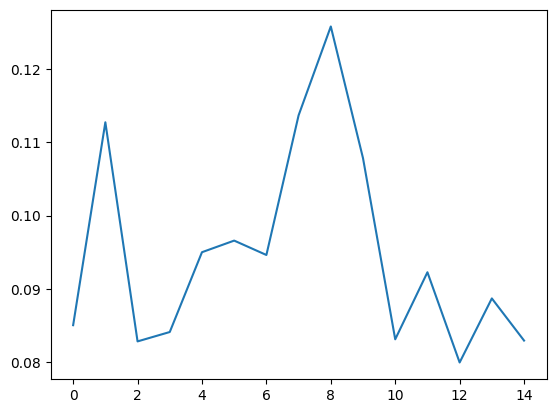

In [31]:
plt.plot(duration_s)
plt.show()

In [ ]:
# Step :4 Speed UP

KV-caching (Key-Value caching) is a powerful technique used in transformer models to enhance the efficiency of generating text, especially during tasks like autoregressive sequence generation where you generate one token at a time. Here’s an overview of how KV-caching works and why it's beneficial:

Basics of KV-Caching
In transformer architectures, the attention mechanism computes outputs by using three sets of weights for each input token: Keys (K), Values (V), and Queries (Q). For sequence generation:

Queries are derived from the token currently being processed.
Keys and Values represent processed tokens and are used to compute the attention output for the query.
During autoregressive generation (where each next token is predicted based on previous tokens), recalculating the keys and values for all previous tokens at each step becomes computationally expensive as the sequence length grows.

How KV-Caching Optimizes Generation
KV-caching optimizes this process by storing the keys and values once they are computed. When a new token is added to the sequence:

Calculate New K and V: Compute keys and values only for the new token.
Cache and Concatenate: Append these new keys and values to the cached keys and values from previous tokens.
Reuse Cached K and V: For the next token prediction, use the cached keys and values without recomputation.
This method avoids the redundancy of recalculating the keys and values for the entire sequence at each generation step, leading to significant reductions in computational overhead and time.

Benefits of KV-Caching
Efficiency: Major reductions in computation time and resource usage because the model reuses previously computed keys and values.
Scalability: Enables the handling of longer sequences by mitigating the linear growth of computational complexity with sequence length.
Performance: Often leads to faster convergence and smoother real-time performance in applications like interactive text generation.
KV-caching is particularly useful in scenarios like chatbots, real-time translation, and other applications where latency is a critical factor and sequences are generated incrementally. This technique is implemented in various transformer models, including GPT-3, where efficiency in generating responses is crucial for user interaction.

In [36]:
prompt = "What is PyTorch?"
inputs = tokenizer(prompt, return_tensors ="pt")

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0,-1,:]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

generated_tokens = list()
next_inputs = inputs 
duration_cached_s = list()

for _ in range(15):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    duration_cached_s.append(time.time() - t0)

    next_inputs = {
        "input_ids": next_token_id.reshape((1,1)), # !!!! keep just last word,
        "attention_mask": torch.cat(  # attention mask updates as usual
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim = 1),
        "past_key_values": past_key_values, # past key values updates 
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print("".join(generated_tokens))
print(f"{sum(duration_cached_s)} s")
print(generated_tokens)




PyTorch is a Python library for generating and manipulating data in
0.6083085536956787 s
['\n', '\n', 'Py', 'Tor', 'ch', ' is', ' a', ' Python', ' library', ' for', ' generating', ' and', ' manipulating', ' data', ' in']


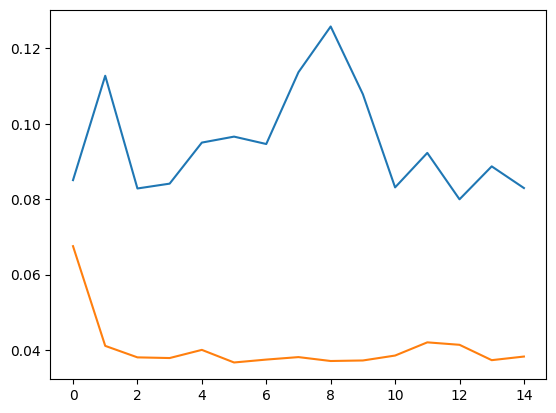

In [37]:
plt.plot(duration_s)
plt.plot(duration_cached_s)
plt.show()